# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult citizen age 18 or older, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:

* Adults are 18+ not 19+, for data availability.

* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.

* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.

* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

* Yang's proposed 0.1% 50-billion-dollar [financial transaction tax](https://www.yang2020.com/policies/financial-transaction-tax/) follows [TPC's distributional impact](https://www.taxpolicycenter.org/sites/default/files/alfresco/publication-pdfs/2000587-financial-transaction-taxes.pdf) (Figure 1).

* Yang's proposed 40-dollar-per-ton [carbon fee-and-dividend](https://www.yang2020.com/policies/carbon-fee-dividend/), half of which would go to the Freedom Dividend, follows the distributional impact shown in Table 5 of [Treasury's 2017 analysis](https://www.treasury.gov/resource-center/tax-policy/tax-analysis/Documents/WP-115.pdf).

* All incidences and income splits are based on the Tax Policy Center's Expanded Cash Income measure, since this is used for the VAT and FTT analysis. After-tax income is assumed to be ECI minus tax.

* Tax units are duplicated and split into 93% citizen per [Kaiser Family Foundation](https://www.kff.org/other/state-indicator/distribution-by-citizenship-status/).

*Data: CPS  |  Tax year: 2021  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.2.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#eeeeee'  # Previously lighter #f5f5f5.

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Major parameters

In [6]:
UBI = 1000 * 12
TOTAL_VAT = 800e9
TOTAL_FTT = 50e9
CARBON_FEE = 40
CARBON_FEE_TPC = 49  # Fee from the paper.
CARBON_FEE_UBI_SHARE = 0.5  # Half goes to UBI, half to other projects.
PCT_CITIZEN = 0.93
# Yang's plan wouldn't be enacted until 2021, but 
# this allows people to enter current income.
YEAR = 2019

## Data

In [7]:
recs = tc.Records.cps_constructor()

List benefits replaced by the Freedom Dividend.

In [8]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

# Exclude health from aftertax_income.
SUBTRACT_VARS = ['mcaid_ben', 'mcare_ben']

In [10]:
# Don't use metric_vars since we'll split later by citizenry.
base0 = tch.calc_df(records=recs, year=YEAR,
                    group_vars=['nu18', 'n1820', 'n21', 'aftertax_income',
                                'expanded_income', 'XTOT'] + 
                    BENS + SUBTRACT_VARS + tch.ECI_REMOVE_COLS)

Duplicate records to make citizens and noncitizens, and create new record IDs.

In [11]:
base_citizen = base0.copy(deep=True)
base_citizen['citizen'] = True
base_citizen.s006 *= PCT_CITIZEN
base_citizen.index = base_citizen.index.astype(str) + 'c'

base_noncitizen = base0.copy(deep=True)
base_noncitizen['citizen'] = False
base_noncitizen.s006 *= 1 - PCT_CITIZEN
base_noncitizen.index = base_noncitizen.index.astype(str) + 'nc'

base = pd.concat([base_citizen, base_noncitizen])

In [12]:
base['afti'] = base.aftertax_income - base[SUBTRACT_VARS].sum(axis=1)
tch.add_weighted_metrics(base, ['afti', 'XTOT'])
base['tpc_eci'] = tch.tpc_eci(base)
tch.add_weighted_quantiles(base, 'tpc_eci')

### Calculations

In [13]:
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
base['adult_citizens'] = base.adults * base.citizen

### Create copy for Yang scenario

TODO: Add a `recalculate` function, starting with market income and adding up from there.

In [14]:
yang = base.copy(deep=True)

In [15]:
yang['max_ubi'] = yang.adult_citizens * UBI
# Adds `ubi` column based on max_ubi and bens. Also adjusts bens.
tch.ubi_or_bens(yang, BENS)

Update ECI.

In [16]:
yang['tpc_eci'] = tch.tpc_eci(yang) + yang.ubi

Weight.

In [17]:
tch.add_weighted_metrics(yang, ['ubi', 'max_ubi', 'bens'])

### VAT, FTT, and carbon tax

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [18]:
tch.add_vat(yang, total=TOTAL_VAT)
vat_rev = tch.weighted_sum(yang, 'vat') / 1e9

Multiplying tax by 1.63.


In [19]:
tch.add_carbon_tax(yang, ratio=CARBON_FEE / CARBON_FEE_TPC)
carbon_tax_rev = tch.weighted_sum(yang, 'carbon_tax') / 1e9

In [20]:
tch.add_ftt(yang, total=TOTAL_FTT)
ftt_rev = tch.weighted_sum(yang, 'ftt') / 1e9

Multiplying tax by 1.49.


In [21]:
pd.Series(index=['vat', 'carbon_tax', 'ftt'],
          data=[vat_rev, carbon_tax_rev, ftt_rev])

vat           800.00
carbon_tax    184.04
ftt            50.00
dtype: float64

In [22]:
NEW_TAX_COLS = ['vat', 'carbon_tax', 'ftt']
yang['new_taxes'] = yang[NEW_TAX_COLS].sum(axis=1)
yang['tax'] = yang.tax + yang.new_taxes

In [23]:
yang['afti'] = yang.afti + yang.ubi - yang.new_taxes  # += doesn't work here.
yang['afti_pre_new_taxes'] = yang.afti - yang.new_taxes
tch.add_weighted_metrics(yang,
                         ['afti', 'tax', 'new_taxes', 'afti_pre_new_taxes'])

### Budgetary impact

In [24]:
tch.add_weighted_metrics(base, ['bens'])

In [25]:
ben_savings_m = yang.bens_m.sum() - base.bens_m.sum()

In [26]:
# In trillions.
budget_t = pd.Series(
    [yang.max_ubi_m.sum(),
     yang.ubi_m.sum(),
     yang.ubi_m.sum() + ben_savings_m,
     yang.ubi_m.sum() + ben_savings_m - yang.new_taxes_m.sum()],
    index = ['Total', 'Excluding\nUBI decliners',
             'Less benefit\nsavings', 'Less new taxes']) / 1e6

In [27]:
budget_t

Total                       2.76
Excluding\nUBI decliners    2.22
Less benefit\nsavings       1.93
Less new taxes              0.89
dtype: float64

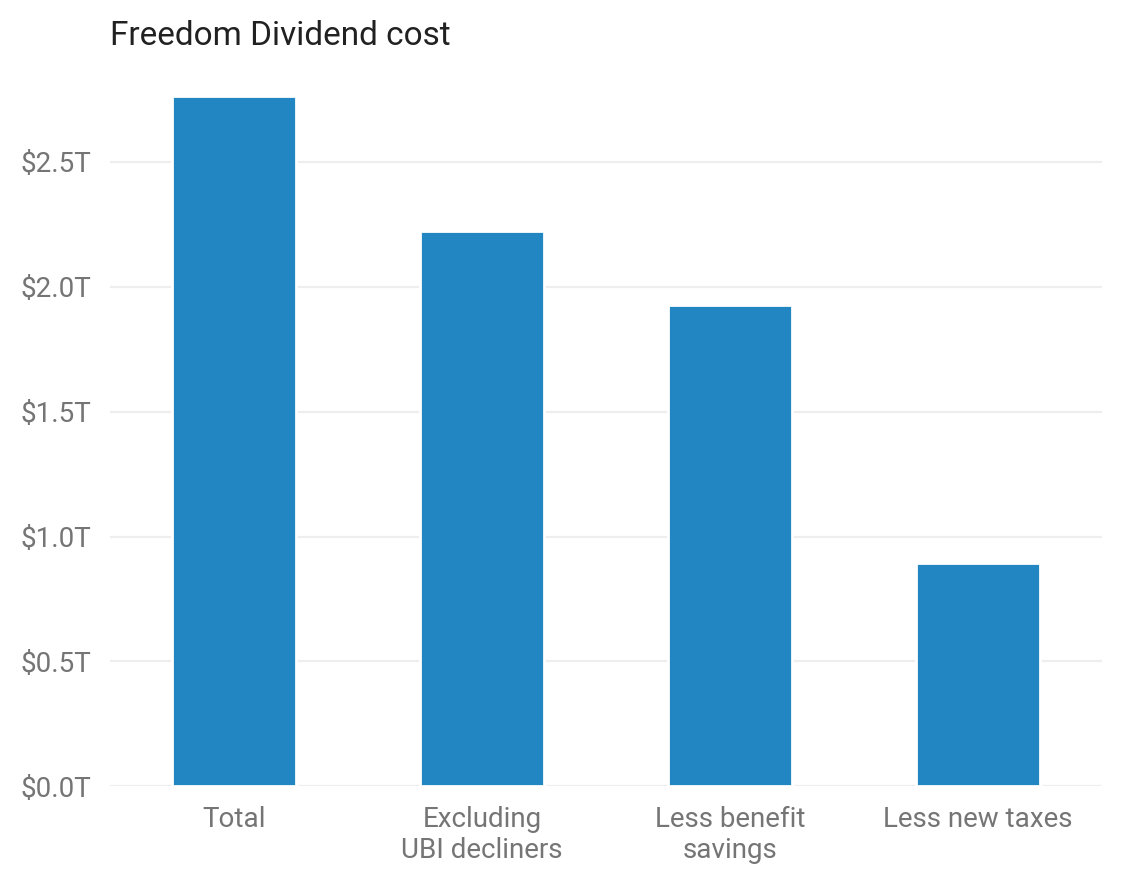

In [28]:
ax = budget_t.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(x, ',') + 'T'))
plt.title('Freedom Dividend cost', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

## Analysis

### Benefit reductions

Exploratory.

In [29]:
BEN_NAME = {
    'e02400': 'Social Security',
    'e02300': 'Unemployment',
    'snap_ben': 'SNAP',
    'ssi_ben': 'SSI',
    'tanf_ben': 'TANF',
    'housing_ben': 'Housing assistance',
    'wic_ben': 'WIC',
    'other_ben': 'Other'
}

In [30]:
ben_reduction_l = []
for i in BENS:
    tmp = pd.DataFrame({
        'base': [tch.weighted_sum(base, i)],
        'yang': [tch.weighted_sum(yang, i)]
    }, index=[i])
    ben_reduction_l.append(tmp)

ben_reduction = pd.concat(ben_reduction_l)
ben_reduction['ben_name'] = ben_reduction.index.map(BEN_NAME)
ben_reduction['reduction'] = ben_reduction.base - ben_reduction.yang
ben_reduction['pct_reduction'] = ben_reduction.reduction / ben_reduction.base
ben_reduction

,base,yang,ben_name,reduction,pct_reduction
snap_ben,8.76e+10,3.44e+10,SNAP,5.32e+10,0.61
ssi_ben,5.23e+10,3.36e+10,SSI,1.87e+10,0.36
tanf_ben,2.99e+10,1.80e+10,TANF,1.20e+10,0.40
wic_ben,3.71e+09,6.07e+08,WIC,3.10e+09,0.84
e02400,1.05e+12,8.66e+11,Social Security,1.88e+11,0.18
e02300,2.19e+10,4.17e+09,Unemployment,1.77e+10,0.81


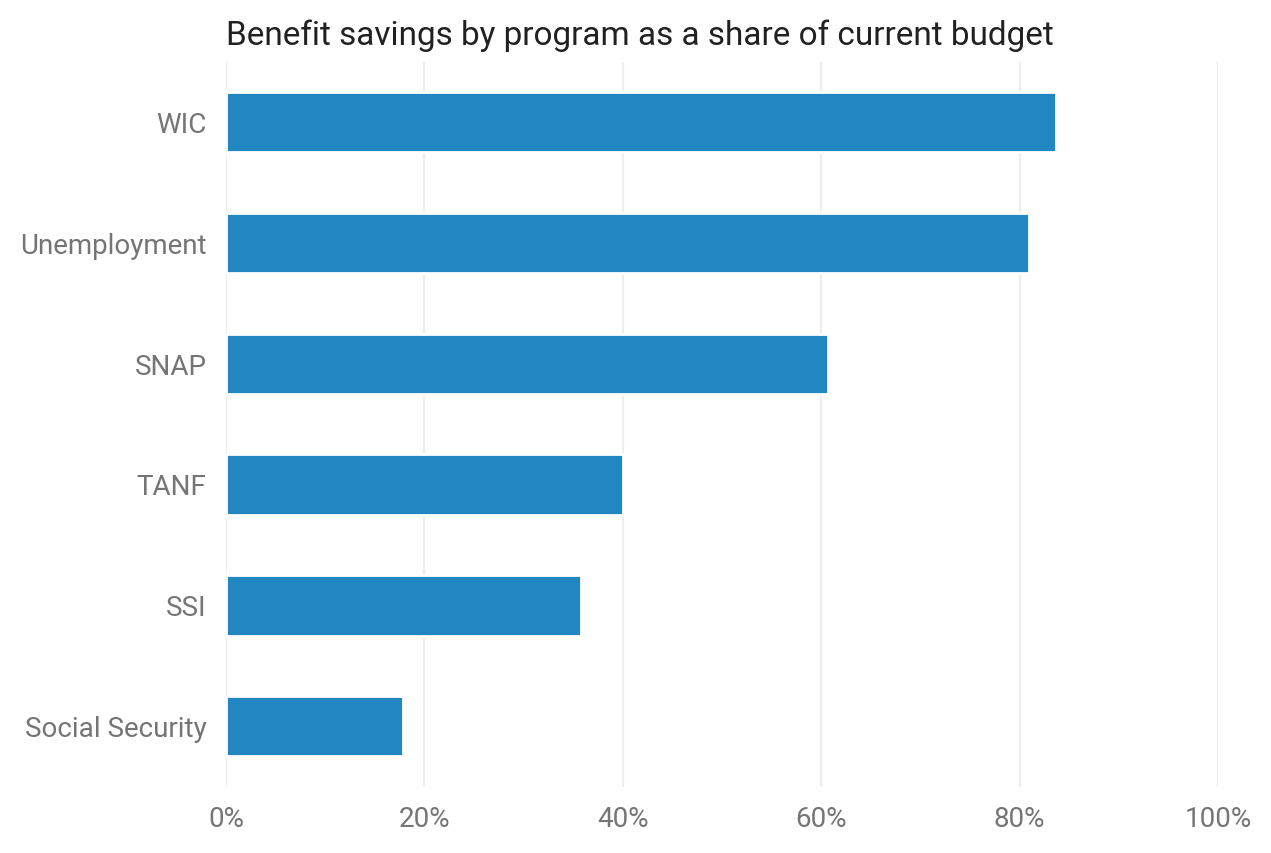

In [31]:
ax = ben_reduction.sort_values('pct_reduction').plot.barh(
    x='ben_name', y='pct_reduction', color='#2286c3')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Benefit savings by program as a share of current budget',
          loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

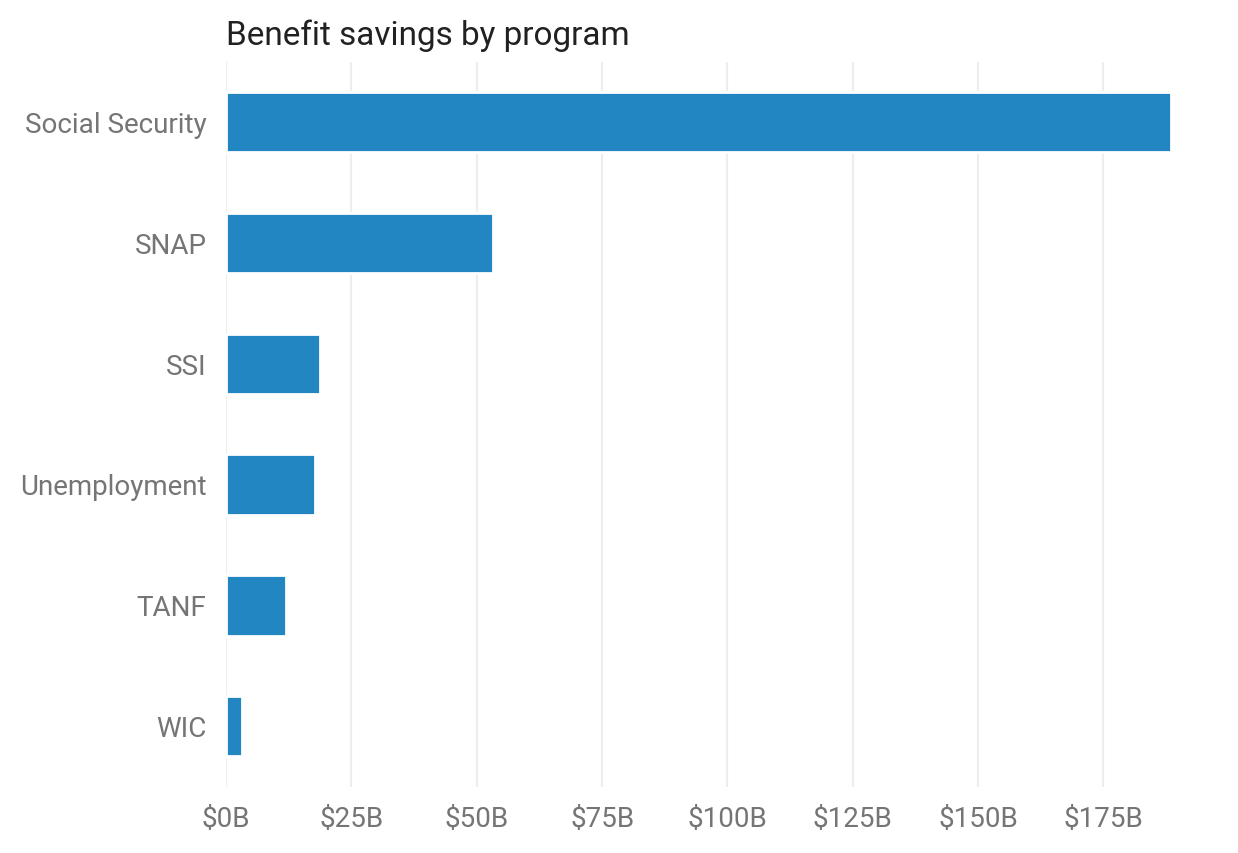

In [32]:
ax = ben_reduction.sort_values('reduction').plot.barh(
    x='ben_name', y='reduction', color='#2286c3')
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1e9), ',') + 'B'))
plt.title('Benefit savings by program', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [33]:
tch.add_weighted_quantiles(base, 'expanded_income')

In [34]:
decile = tch.agg(base, yang, groupby='expanded_income_decile', metrics='afti',
                 base_metrics='s006', 
                 reform_metrics=['new_taxes_m', 'afti_pre_new_taxes_m'])

In [35]:
decile

,s006,afti_m_base,afti_m_reform,afti_pre_new_taxes_m,new_taxes_m,afti_pctchg
expanded_income_decile,,,,,,
0,5.03e+04,-1.40e+04,-1.32e+04,-1.32e+04,3.74,-5.52e-02
1,1.65e+07,1.55e+05,3.26e+05,3.00e+05,25452.36,1.10e+00
2,1.65e+07,3.33e+05,4.86e+05,4.45e+05,40896.18,4.61e-01
3,1.65e+07,4.29e+05,5.52e+05,5.03e+05,48684.67,2.86e-01
4,1.65e+07,5.43e+05,6.76e+05,6.17e+05,59247.81,2.46e-01
5,1.65e+07,6.69e+05,8.05e+05,7.34e+05,71427.08,2.03e-01
6,1.65e+07,8.24e+05,9.52e+05,8.66e+05,85855.24,1.55e-01
7,1.65e+07,1.04e+06,1.17e+06,1.07e+06,104805.63,1.25e-01
8,1.65e+07,1.35e+06,1.47e+06,1.34e+06,128787.69,9.08e-02


In [36]:
decile['afti_chg_m'] = decile.afti_m_reform - decile.afti_m_base

In [37]:
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.afti_m_base
decile['new_taxes'] = 1e6 * decile.new_taxes_m / decile.s006
decile['new_taxes_pct'] = decile.new_taxes_m / decile.afti_pre_new_taxes_m
decile.drop(0, inplace=True)  # Negative income.
decile

,s006,afti_m_base,afti_m_reform,afti_pre_new_taxes_m,new_taxes_m,afti_pctchg,afti_chg_m,afti_chg,afti_chg_pct,new_taxes,new_taxes_pct
expanded_income_decile,,,,,,,,,,,
1,1.65e+07,1.55e+05,3.26e+05,3.00e+05,25452.36,1.10e+00,170759.52,10364.15,1.10e+00,1544.82,0.08
2,1.65e+07,3.33e+05,4.86e+05,4.45e+05,40896.18,4.61e-01,153474.07,9286.66,4.61e-01,2474.61,0.09
3,1.65e+07,4.29e+05,5.52e+05,5.03e+05,48684.67,2.86e-01,122674.20,7422.74,2.86e-01,2945.80,0.10
4,1.65e+07,5.43e+05,6.76e+05,6.17e+05,59247.81,2.46e-01,133699.18,8089.92,2.46e-01,3584.99,0.10
5,1.65e+07,6.69e+05,8.05e+05,7.34e+05,71427.08,2.03e-01,136029.39,8231.20,2.03e-01,4322.09,0.10
6,1.65e+07,8.24e+05,9.52e+05,8.66e+05,85855.24,1.55e-01,127355.16,7706.15,1.55e-01,5195.03,0.10
7,1.65e+07,1.04e+06,1.17e+06,1.07e+06,104805.63,1.25e-01,130287.84,7883.30,1.25e-01,6341.45,0.10
8,1.65e+07,1.35e+06,1.47e+06,1.34e+06,128787.69,9.08e-02,122457.56,7409.77,9.08e-02,7792.80,0.10
9,1.65e+07,1.87e+06,1.97e+06,1.81e+06,166953.93,5.25e-02,98343.49,5950.87,5.25e-02,10102.57,0.09


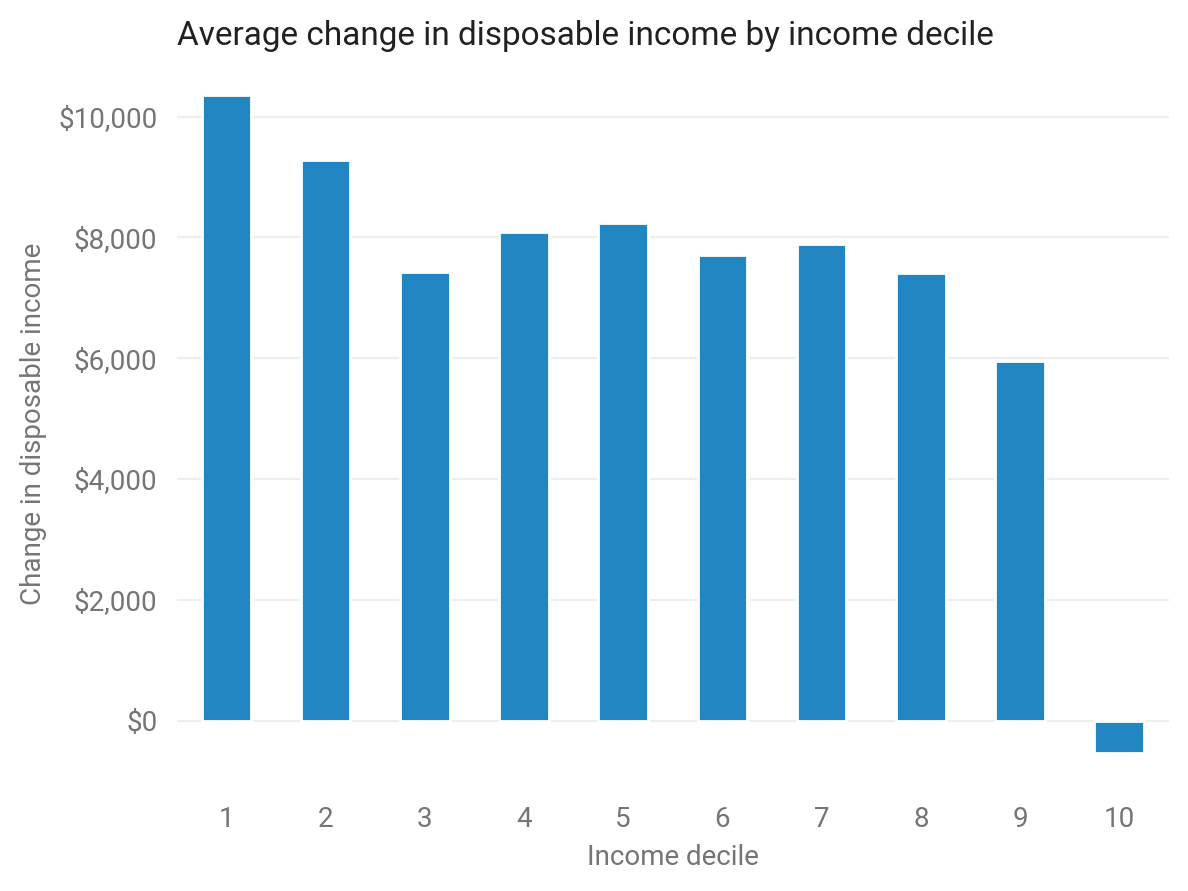

In [38]:
ax = decile.afti_chg.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in disposable income')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

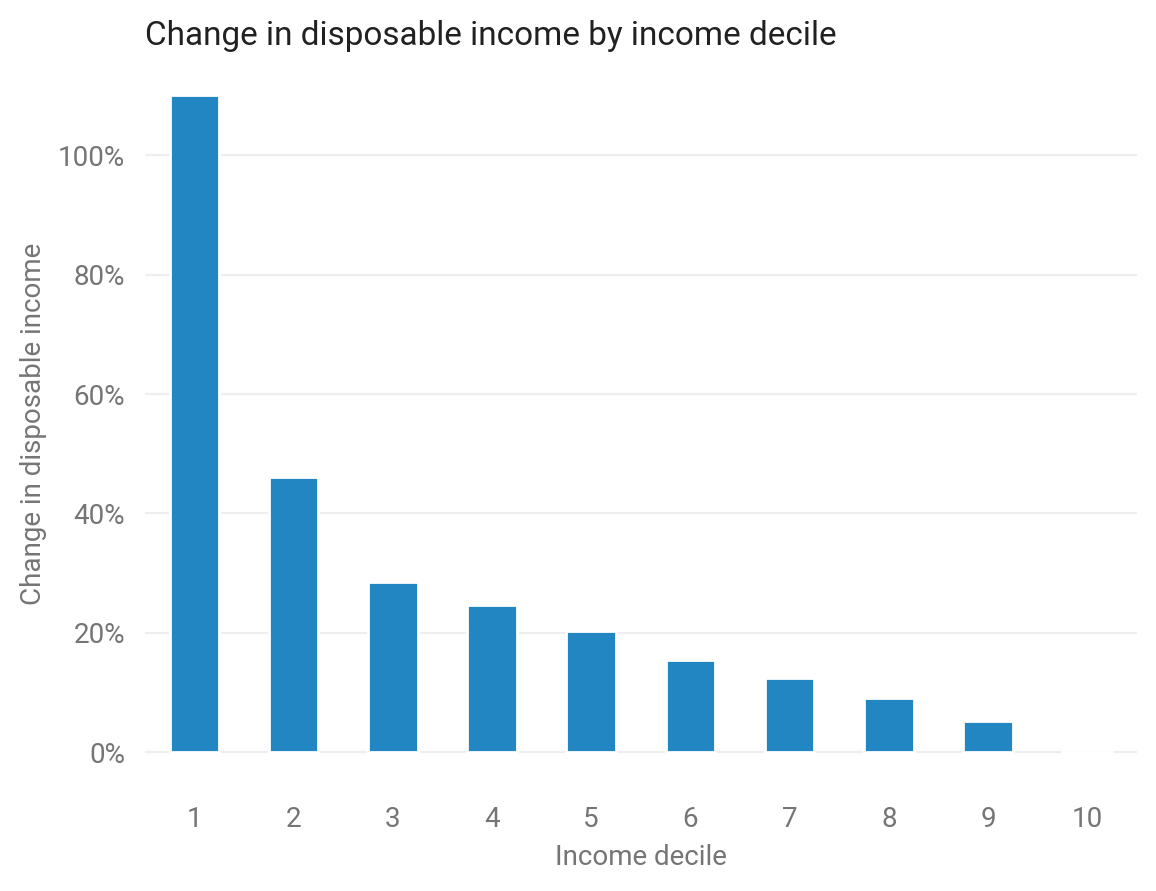

In [39]:
ax = decile.afti_chg_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.xticks(rotation=0)
plt.title('Change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in disposable income')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.show()

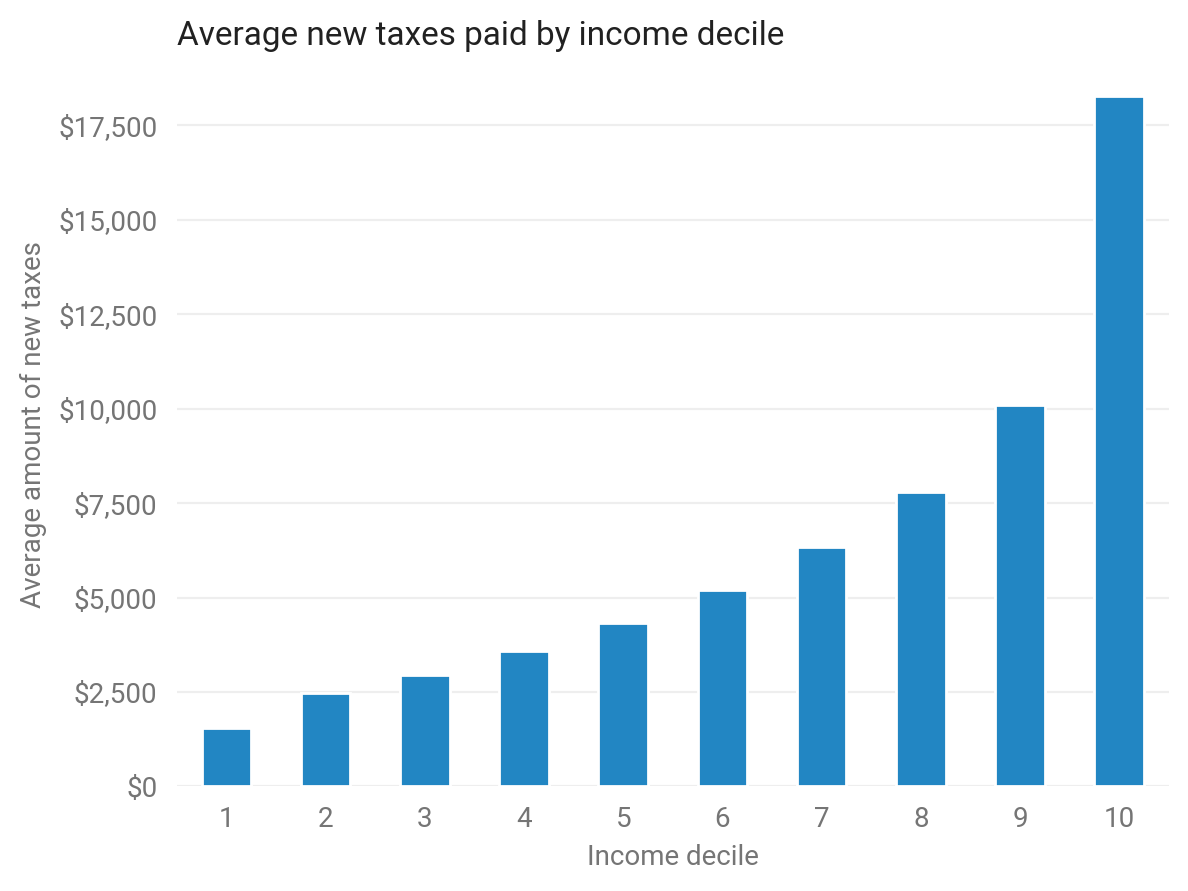

In [40]:
ax = decile.new_taxes.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average new taxes paid by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Average amount of new taxes')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

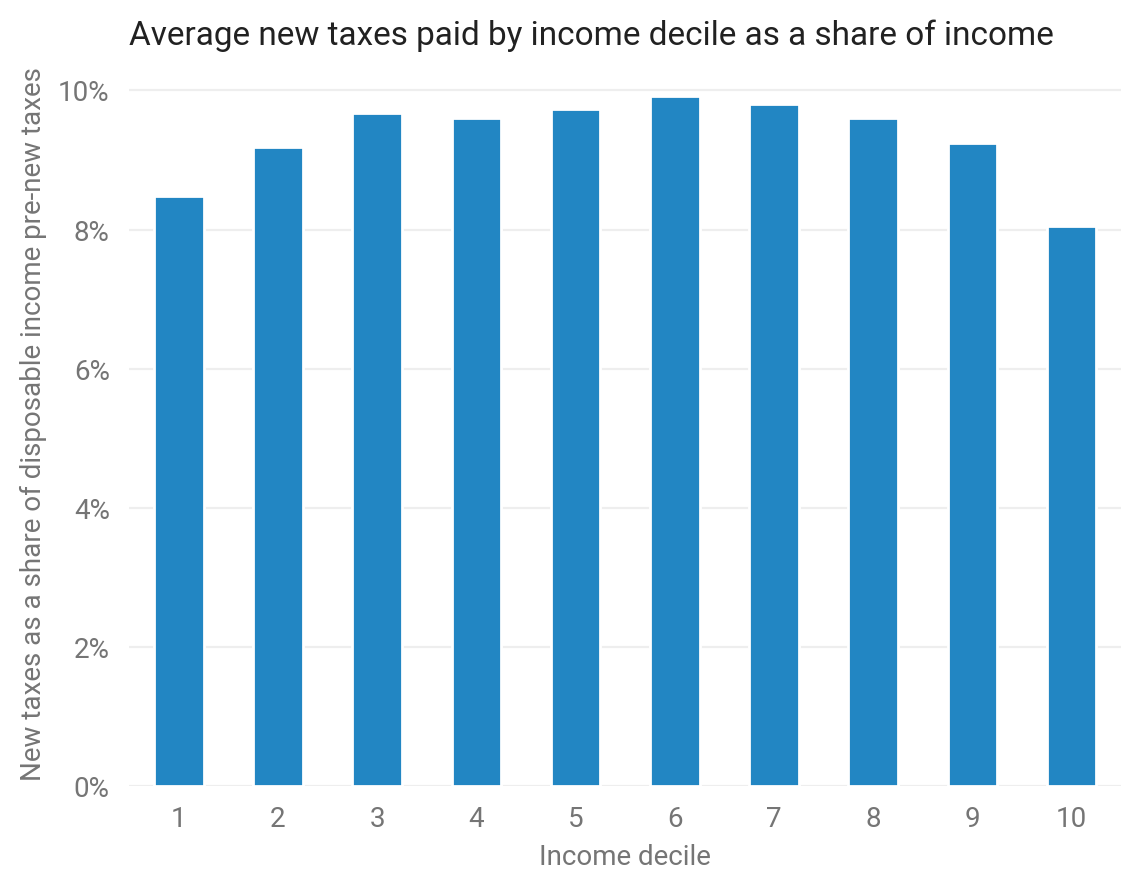

In [41]:
ax = decile.new_taxes_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Average new taxes paid by income decile as a share of income',
          loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('New taxes as a share of disposable income pre-new taxes')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

### DIstribution of household-level changes

`br` for `b`ase-`r`eform.

In [86]:
br = tch.combine_base_reform(
    base, yang,
    base_cols=['expanded_income', 's006', 'XTOT', 'XTOT_m', 'market_income'],
    cols=['afti', 'tax', 'bens'], reform_cols='ubi')

In [87]:
br.afti_noneg_base = np.maximum(br.afti_base, 0)
br['afti_chg'] = br.afti_reform - br.afti_base
# Check for zeros to avoid 0/0 NaNs.
br['afti_pctchg'] = np.where(br.afti_chg == 0, 0,
                             br.afti_chg / br.afti_noneg_base)

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [88]:
br['winner'] = br.afti_reform > br.afti_base

In [89]:
EI_BIN_LABELS = ['Less than \$10K', '\$10K to \$20K', '\$20K to \$30K', 
                 '\$30K to \$40K', '\$40K to \$50K', '\$50K to \$75K', 
                 '\$75K to \$100K', '\$100K to \$200K', '\$200K to \$500K', 
                 '\$500K to \$1M', '\$1M or more']
br['ei_bin'] = (
    pd.cut(br.expanded_income.astype('int'),
           pd.Series([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, np.inf])
           * 1000,
           labels=EI_BIN_LABELS))

In [90]:
DI_PCTCHG_BIN_LABELS = [
    'Decrease greater than 5%', 'Decrease less than 5%',
    'Increase less than 5%', 'Increase greater than 5%']
br['afti_pctchg_bin'] = pd.cut(
    br.afti_pctchg,
    [-np.inf, -0.05, 0, 0.05, np.inf],
    labels=DI_PCTCHG_BIN_LABELS)

In [91]:
def combined_pivot(group_bin, chg_bin, weight, exclude_negs=True):
    if exclude_negs:
        df = br[(br.afti_reform > 0) & (br.afti_base > 0) &
                (br.expanded_income > 0)]
    else:
        df = br
    pivot = df.pivot_table(index=group_bin, columns=chg_bin, 
                           values=weight, aggfunc=sum, fill_value=0)
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
    pivot_total = df.pivot_table(columns=chg_bin, 
                                 values=weight, aggfunc=sum, fill_value=0)
    pivot_total_pct = pivot_total.div(pivot_total.sum(axis=1), axis=0)
    pivot_total_pct.index = ['Total']
    # Create empty row to distinguish total row.
#     pivot_empty = pd.Series(name='')
    pivot_empty = pivot_total_pct.copy()
    pivot_empty.loc[:] = None
    pivot_empty.index = ['']
    # Can't concat in the correct order:
    # TypeError: cannot append a non-category item to a CategoricalIndex
    # Instead reorder in a separate step.
    pivot_combined_pct = pd.concat([pivot_total_pct, pivot_pct, pivot_empty])
    return pivot_combined_pct.iloc[1:].append(
        pivot_combined_pct.iloc[0]).iloc[:, ::-1]

In [92]:
COLORS = ['#004ba0',  # Dark blue.
          '#63a4ff',  # Light blue.
#           '#e0e0e0',  # Gray.  Remove the under-1% change group.
          '#ffc046',  # Light amber.
          '#c56000']  # Medium amber.

In [93]:
def dist_plot(income_bin, chg_bin, weight):
    ax = combined_pivot(income_bin, chg_bin, weight).plot.barh(
        stacked=True, color=COLORS, width=0.97, figsize=(11, 8))
    legend = plt.legend(bbox_to_anchor=(-0.005, 1.0, 0.96, .102), loc=3,
                        ncol=5, mode='expand', borderaxespad=0.,
                        frameon=False)
    plt.setp(plt.gca().get_legend().get_texts(), fontsize=7.5)
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
    ax.set(xlabel='', 
           ylabel='Household income')
    plt.title('Distribution of ' +
              ('tax returns' if weight == 's006' else 'people') + ' by ' +
              ('size of tax change' if chg_bin == 'tax_chg_bin'
               else 'effect on disposable income'),
              loc='left', y=1.05, fontsize=16)
    return ax

In [94]:
combined_pivot('ei_bin', 'afti_pctchg_bin', 's006')

afti_pctchg_bin,Increase greater than 5%,Increase less than 5%,Decrease less than 5%,Decrease greater than 5%
Less than \$10K,8.07e-01,0.00e+00,0.00e+00,0.19
\$10K to \$20K,8.59e-01,0.00e+00,0.00e+00,0.14
\$20K to \$30K,8.11e-01,0.00e+00,0.00e+00,0.19
\$30K to \$40K,6.73e-01,0.00e+00,0.00e+00,0.33
\$40K to \$50K,7.17e-01,0.00e+00,0.00e+00,0.28
\$50K to \$75K,7.08e-01,0.00e+00,0.00e+00,0.29
\$75K to \$100K,7.05e-01,9.56e-04,0.00e+00,0.29
\$100K to \$200K,6.00e-01,9.78e-02,2.07e-03,0.30
\$200K to \$500K,2.96e-01,3.52e-01,9.31e-02,0.26
\$500K to \$1M,4.82e-03,5.36e-02,6.57e-01,0.28


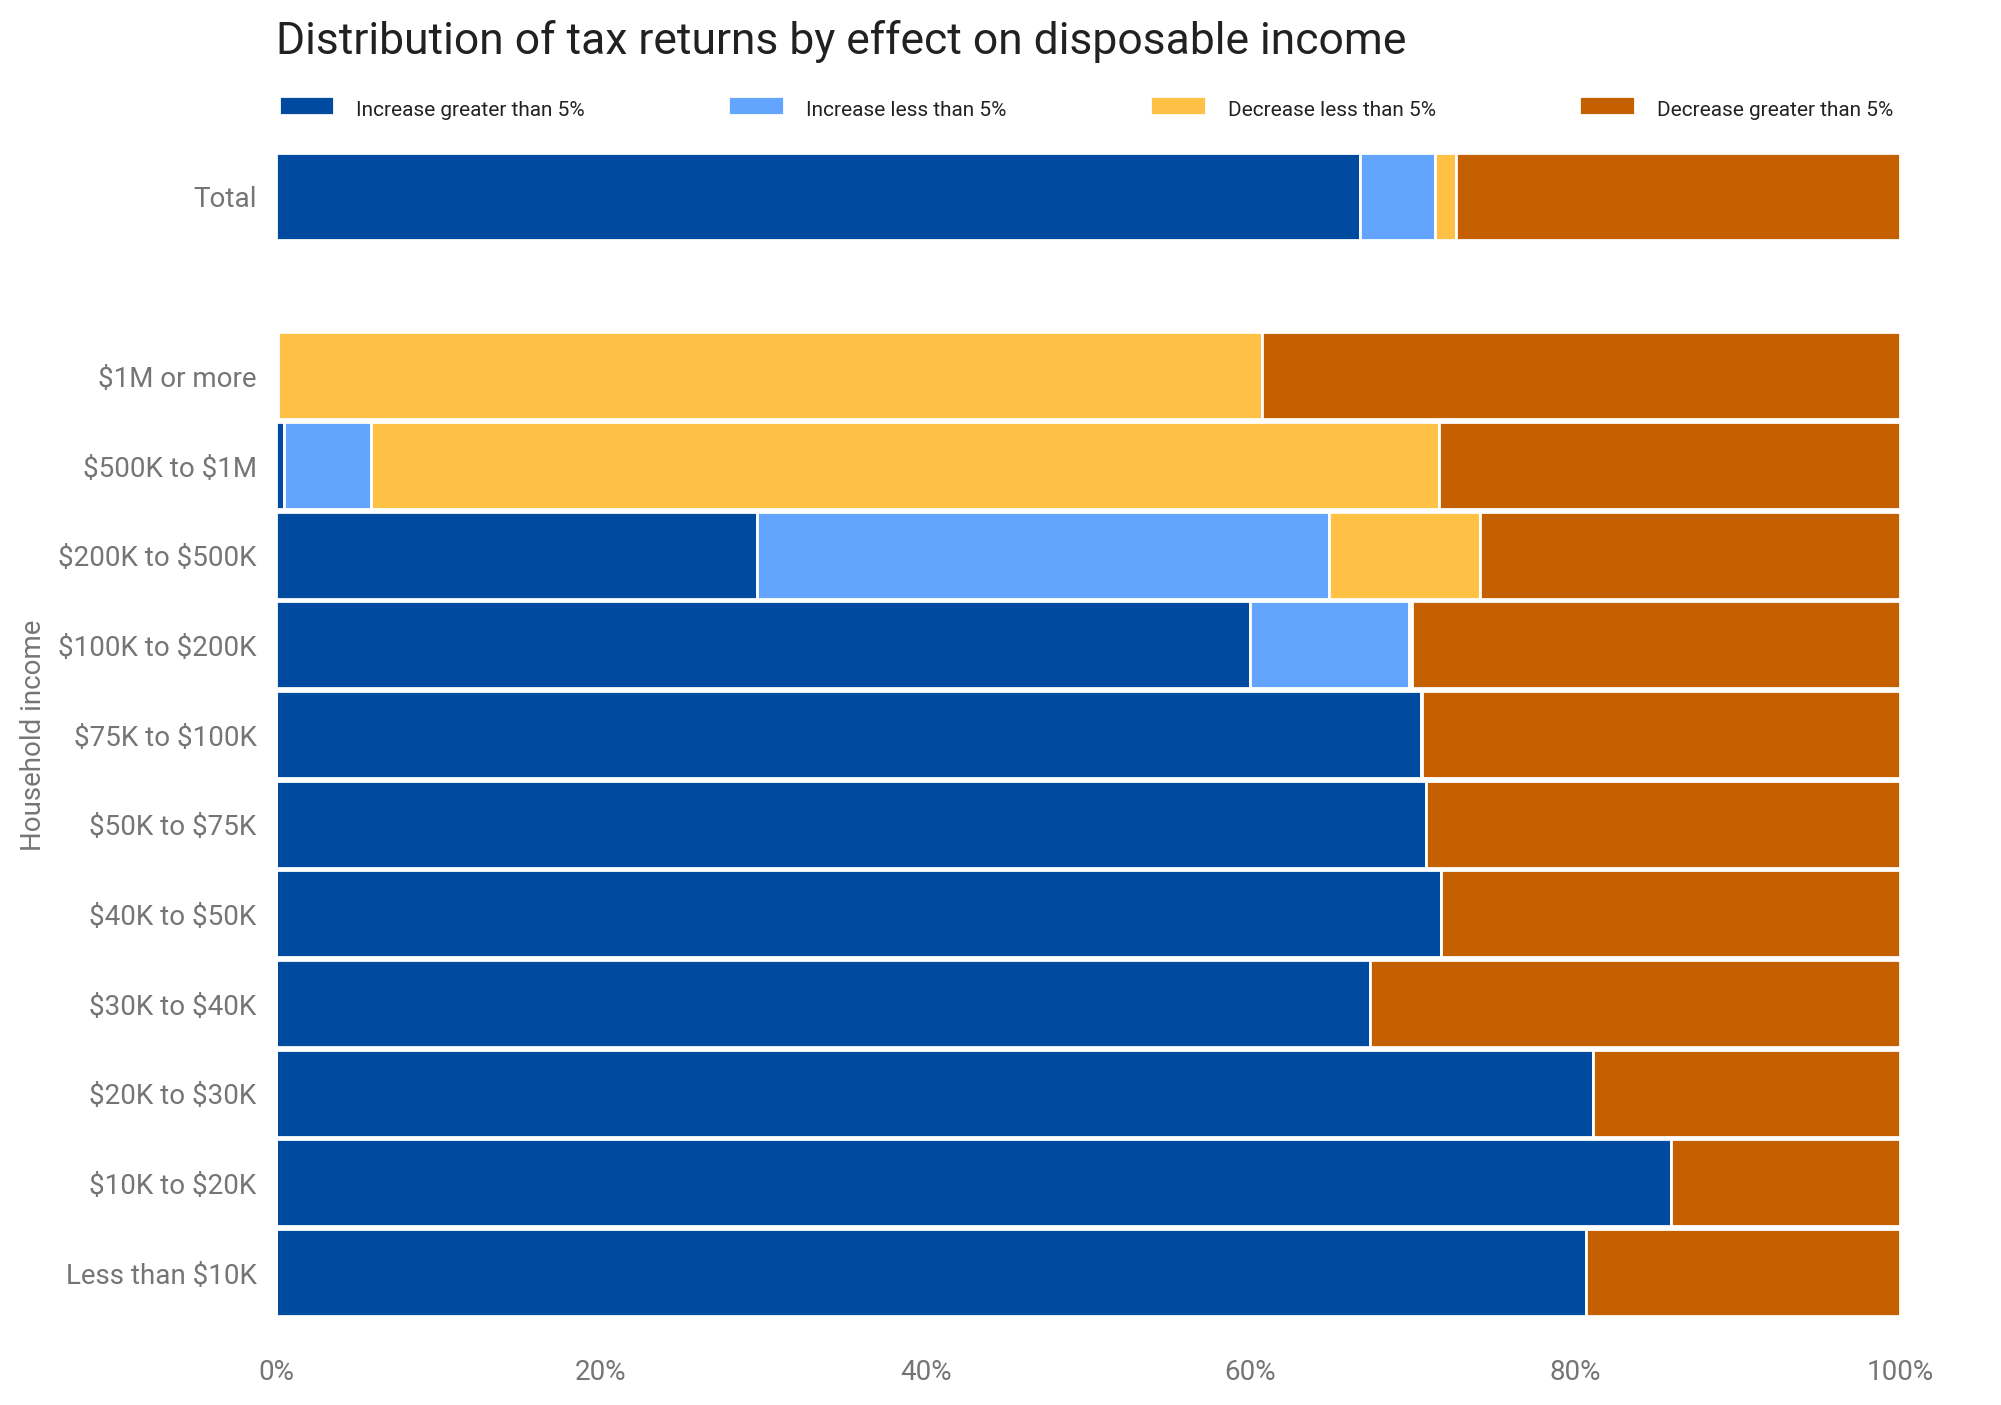

In [95]:
ax = dist_plot('ei_bin', 'afti_pctchg_bin', 's006')

In [96]:
combined_pivot('ei_bin', 'afti_pctchg_bin', 'XTOT_m')

afti_pctchg_bin,Increase greater than 5%,Increase less than 5%,Decrease less than 5%,Decrease greater than 5%
Less than \$10K,8.29e-01,0.00e+00,0.00e+00,0.17
\$10K to \$20K,8.75e-01,0.00e+00,0.00e+00,0.12
\$20K to \$30K,8.41e-01,0.00e+00,0.00e+00,0.16
\$30K to \$40K,7.49e-01,0.00e+00,0.00e+00,0.25
\$40K to \$50K,7.87e-01,0.00e+00,0.00e+00,0.21
\$50K to \$75K,7.64e-01,0.00e+00,0.00e+00,0.24
\$75K to \$100K,7.59e-01,6.24e-04,0.00e+00,0.24
\$100K to \$200K,7.02e-01,5.41e-02,1.32e-03,0.24
\$200K to \$500K,3.49e-01,3.90e-01,5.07e-02,0.21
\$500K to \$1M,9.62e-03,8.02e-02,6.82e-01,0.23


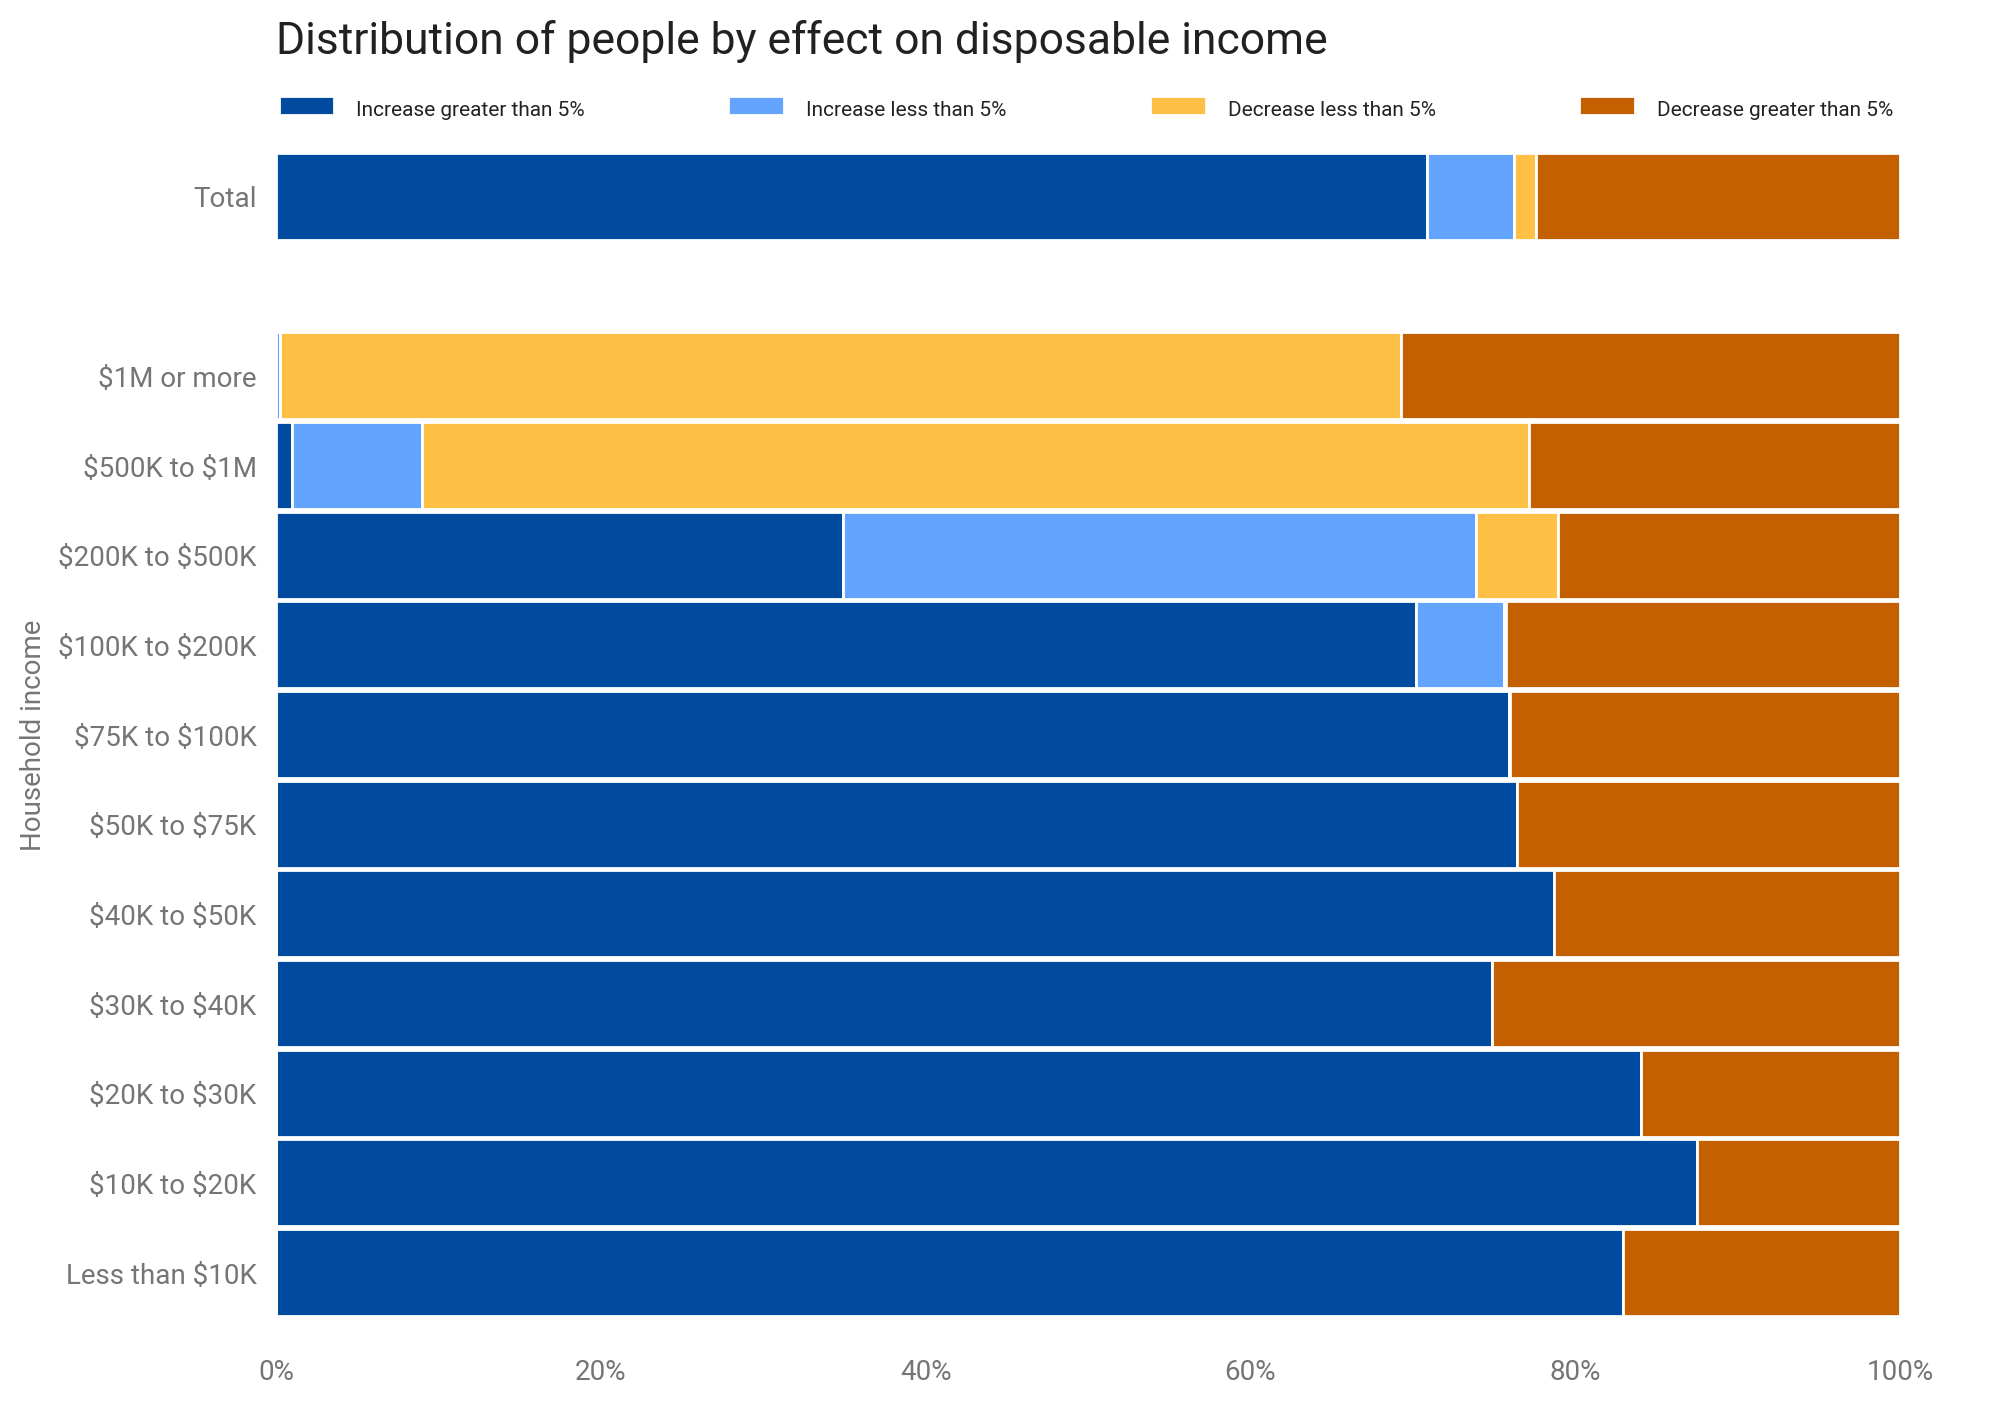

In [97]:
ax = dist_plot('ei_bin', 'afti_pctchg_bin', 'XTOT_m')

### Poverty

In [98]:
def fpl_rate(df, income_col):
    fpl_count = df[df[income_col] < tch.fpl(df.XTOT)].XTOT_m.sum()
    return fpl_count / df.XTOT_m.sum()

In [109]:
fpls = pd.Series([
    fpl_rate(br, 'market_income'),
    fpl_rate(br, 'afti_base'),
    fpl_rate(br, 'afti_reform')
], index = ['Initial\nmarket\nincome',
            'Disposable\nincome\n(Baseline)',
            'Disposable\nincome\n($1,000 UBI)'])
fpls * 100

Initial\nmarket\nincome             22.56
Disposable\nincome\n(Baseline)       7.29
Disposable\nincome\n($1,000 UBI)     2.13
dtype: float64

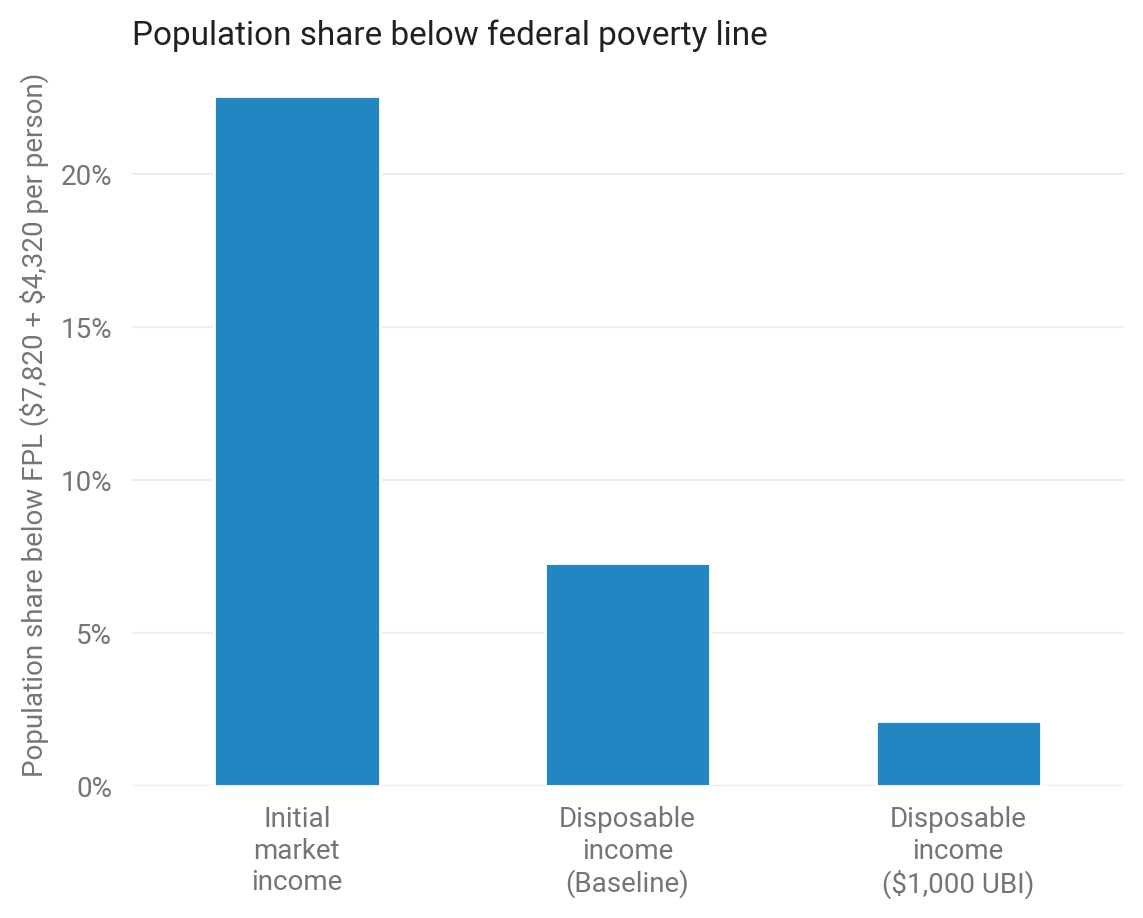

In [110]:
ax = fpls.plot.bar(color='#2286c3')
plt.title('Population share below federal poverty line', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.ylabel('Population share below FPL (\$7,820 + $4,320 per person)')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

### Inequality

#### Gini

In [111]:
ginis = pd.Series([
    tch.gini(br.market_income, br.XTOT_m),
    tch.gini(br.afti_base, br.XTOT_m),
    tch.gini(br.afti_reform, base.XTOT_m),
], index = ['Initial\nmarket\nincome', 'Disposable\nincome\n(Baseline)',
            'Disposable\nincome\n($1,000 UBI)'])
ginis * 100

Initial\nmarket\nincome             57.65
Disposable\nincome\n(Baseline)      45.87
Disposable\nincome\n($1,000 UBI)    40.62
dtype: float64

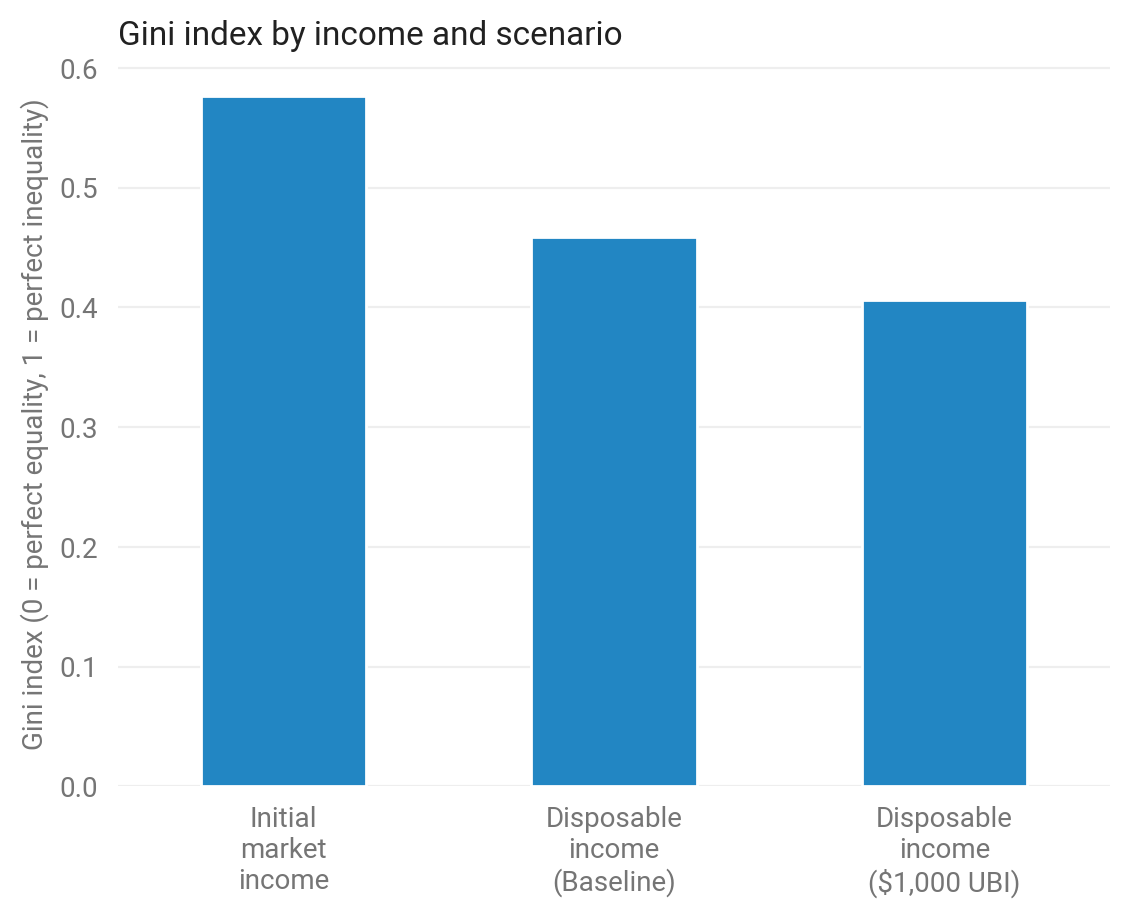

In [112]:
ax = ginis.plot.bar(color='#2286c3')
plt.title('Gini index by income and scenario', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Gini index (0 = perfect equality, 1 = perfect inequality)')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

#### Share of top 1%

In [119]:
tch.add_weighted_quantiles(br, 'market_income')
tch.add_weighted_quantiles(br, 'afti_base')
tch.add_weighted_quantiles(br, 'afti_reform')

In [120]:
def top_1pct(df, col):
    return(tch.weighted_sum(df[df[col + '_percentile'] == 100], col) /
           tch.weighted_sum(df, col))

In [121]:
top1pcts = pd.Series([
    top_1pct(br, 'market_income'),
    top_1pct(br, 'afti_base'),
    top_1pct(br, 'afti_reform')
], index = ['Initial\nmarket\nincome', 'Disposable\nincome\n(Baseline)',
            'Disposable\nincome\n($1,000 UBI)'])
top1pcts * 100

Initial\nmarket\nincome             13.41
Disposable\nincome\n(Baseline)      10.36
Disposable\nincome\n($1,000 UBI)     8.99
dtype: float64

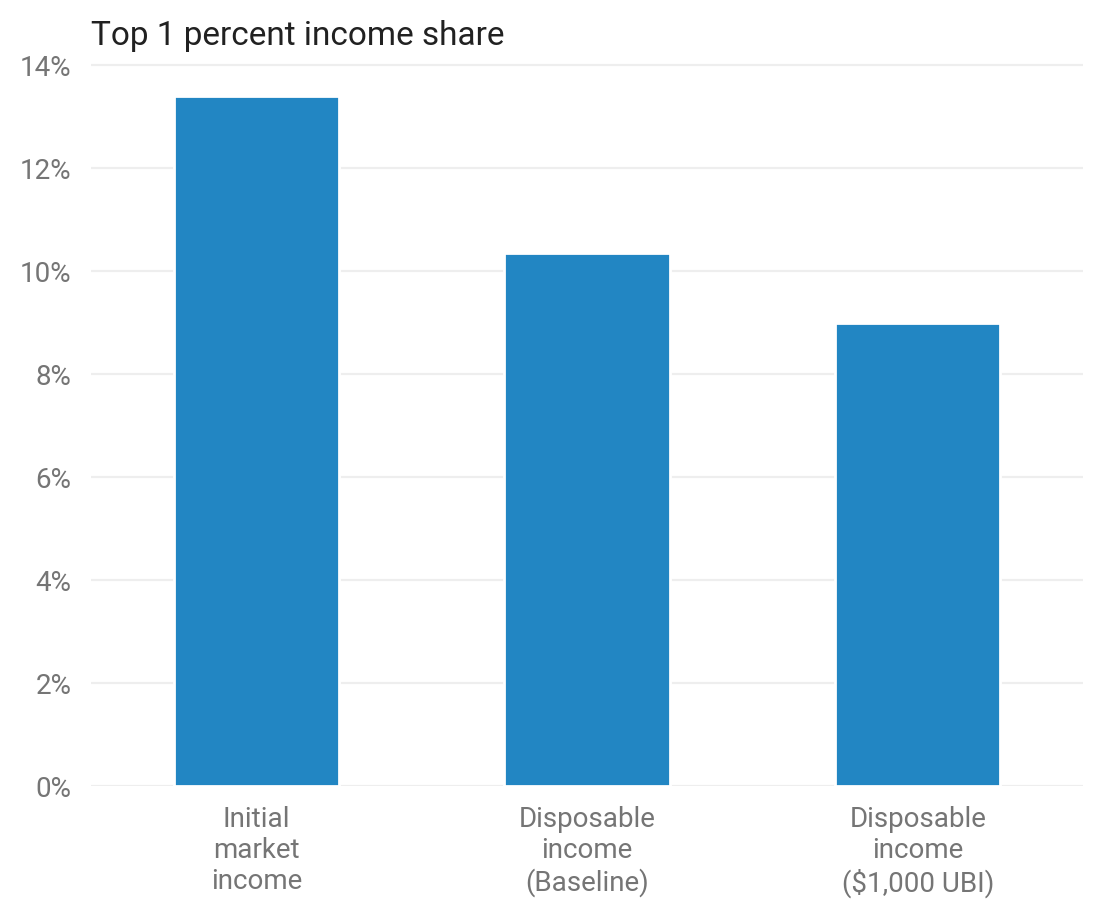

In [122]:
ax = top1pcts.plot.bar(color='#2286c3')
plt.title('Top 1 percent income share', loc='left')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

### Change in deciles

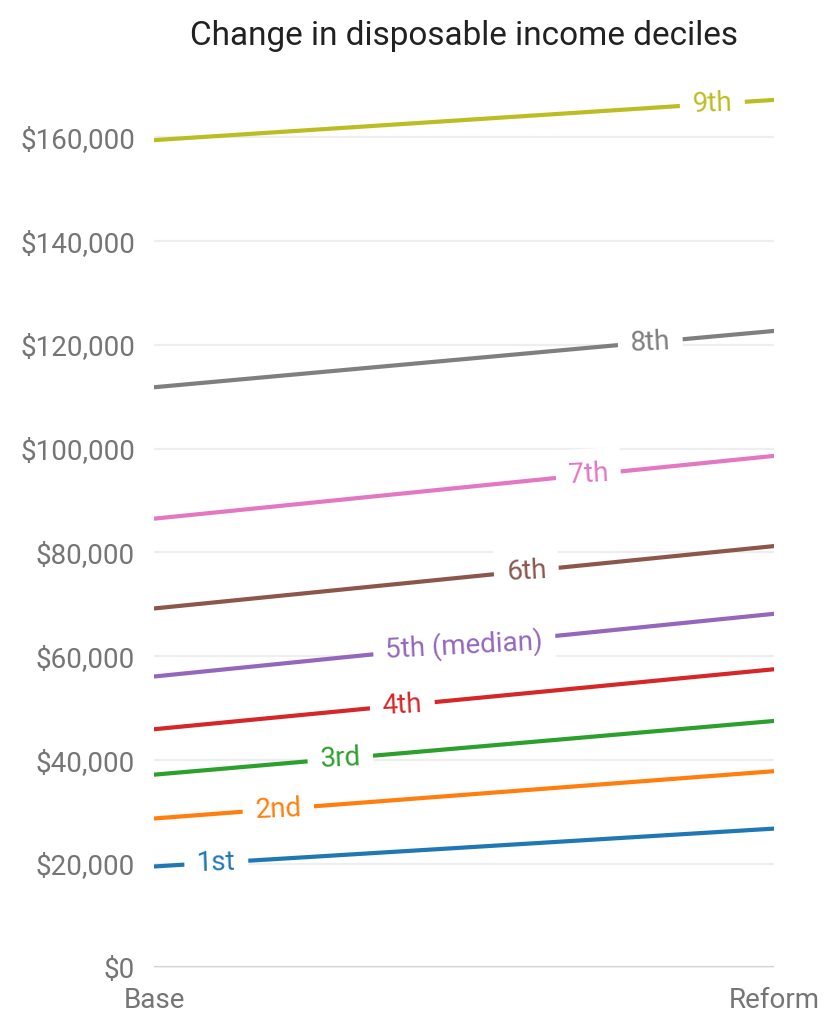

In [123]:
ax = tch.quantile_chg_plot(br.afti_base, br.afti_reform,
                           br.XTOT_m, br.XTOT_m)
ax.grid(color=GRID_COLOR, axis='y')
fmt = mpl.ticker.FuncFormatter(lambda x, _: '$' + format(int(x), ','))
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_minor_formatter(fmt)
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
#     lambda x, _: '$' + format(int(x), ',')))
plt.gcf().set_size_inches(4, 6)
plt.show()

## Normalize

In [124]:
qchg = tch.quantile_chg(br.afti_base, br.afti_reform,
                        br.XTOT_m, br.XTOT_m).transpose()
qchg.columns = ['base', 'reform']
qchg['pct_chg'] = qchg.reform / qchg.base - 1
qchg

,base,reform,pct_chg
1st,19482.70,26781.13,0.37
2nd,28729.20,37845.33,0.32
3rd,37176.02,47527.55,0.28
4th,45931.25,57492.39,0.25
5th (median),56093.51,68177.77,0.22
6th,69208.45,81227.83,0.17
7th,86511.86,98609.62,0.14
8th,111837.22,122688.97,0.10
9th,159458.03,167213.62,0.05


In [125]:
qchg['index_newline'] = np.where(qchg.index == '5th (median)', '5th\n(median)', qchg.index)

/home/max/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


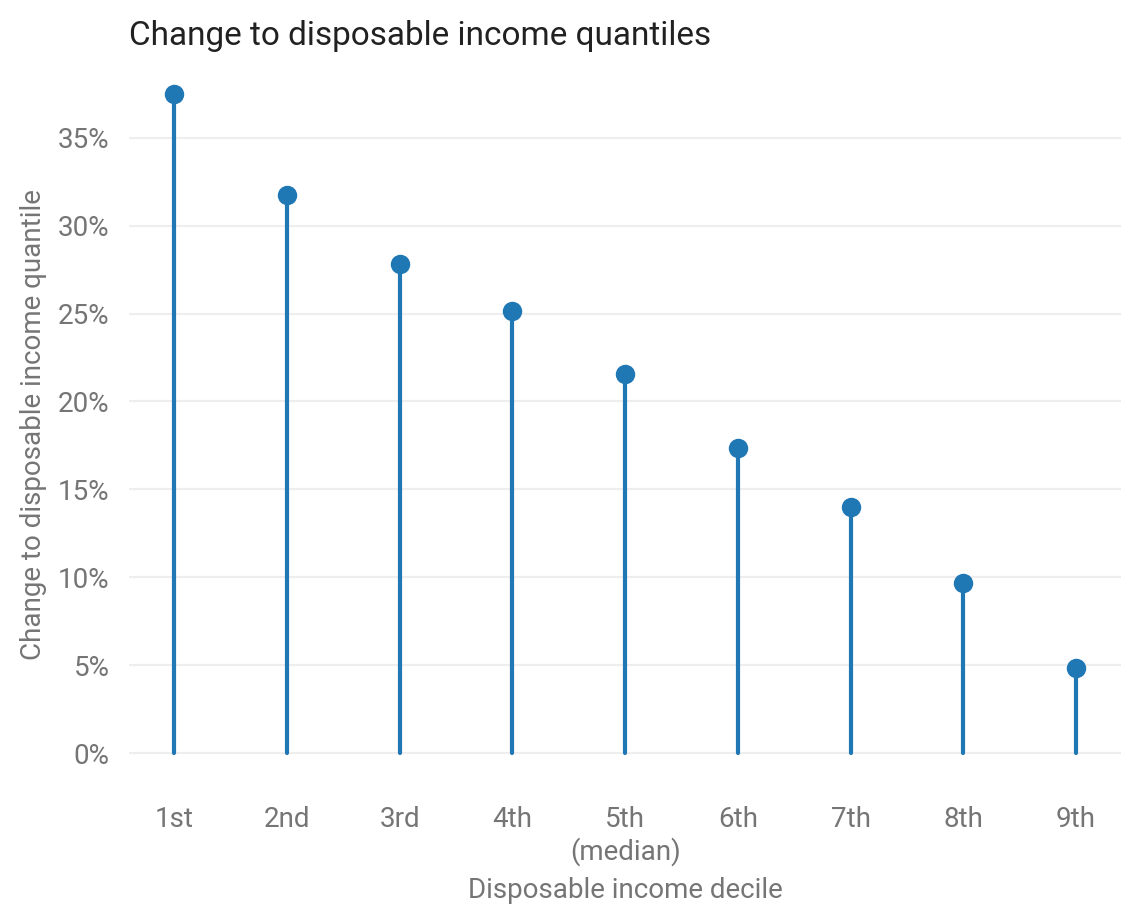

In [126]:
fig, ax = plt.subplots()
markerline, stemlines, baseline = ax.stem(qchg.index_newline, qchg.pct_chg)
plt.setp(baseline, color='gray', linewidth=0)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change to disposable income quantiles', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change to disposable income quantile')
plt.xlabel('Disposable income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()